# Influence Maximisation Problem with time and random delays

This is the issue of maximising value in a netowork by selecting nodes that are most likely to yield the highest value. In this notebook we will implement some well studied models and extend them to account for time delays. We will design heuristic and greedy strategies to tackle the influence maximisation problem and analyse performance of the algorithms.

## Jargon: understanding vocabulary

Here we put some vocabulary we might need in order to understand and tackle the problem.

* **States** is how we represent the node, 0 is inactive, -1 latent active, and 1 is active.
* **Propagation value** PV(S) is the expected value of activated nodes in a seed set, S.
* **Seed set** is the set of nodes that contain the solution.
* **k seeds** is the number of initial set of nodes before starting influence maximisation.
* **Freashness function** is a function to determine the value of a node with respect to the time till activation.
* **Freashness value** is the actual value of the node.


In [1]:
# Import packages
import matplotlib.pyplot as plt
from random import uniform, seed
import numpy as np
import time
import snap
import networkx as nx
import random
import itertools
import urllib
import csv
import functools
import heapq as h
import re
import operator
from math import floor
from statistics import mean, stdev

## Generate time sensitive network

In [2]:
def gen_ts_graph(size, seed=1000, pr=1):
    """
    input: size - size of the graph, seed - same seed same random number
    output: Creates a network with time delay on edges, and the capability to add three states.
    """
    random.seed(seed*size)
    G = snap.GenRndGnm(snap.PNEANet, size, random.randrange(size*3, round(size*(size - 1)/150, 0)))
            
    if pr:
        print("Graph successfully generated! \n")
            
    return G

In [6]:
graph1 = gen_ts_graph(2500, 5)

Graph successfully generated! 



### Freshness functions - 3 variants

In [3]:
def exponential(x):
    """
    input: x - function input
    output: y - function output
    """
    if x >= 0:
        return (np.exp(1)**(x*-0.2))
    else:
        return 0

def polynomialFreeDecay(x):
    """
    input: x - function input
    output: y - function output
    """
    if x >= 0:
        return (-0.35*x)+5
    else:
        return 0
    
def piecewiselinear(x):
    """
    input: x - function input
    output: y - function output
    """
    if x >= 0 and x < 5:
        return 0.8+(1/(x+1))
    elif x >= 5  and x < 10:
        return (x-1)**0.5 - 1.7
    elif x >= 10:
        return -0.01*x+2.2
    else:
        return 0

## Time Sensitive Independent Cascade

In [4]:
def ic(g, s, p=0.5, mc=100, method=exponential):
    """ 
    input: g - graph, s - seed set, mc - number of montecarlo simulations, p - the activaiton probability
    output: average propagation value
    """

    #result of mc simulations
    pvS = []
    
    for i in range(mc):
        #propagate under ic style
        aCurr, allActive, latentA, latentDict, pv = s.copy(), s.copy(), [], {}, 0
        count = 0
        
        while aCurr or latentA:
            
            #neighbors of the nodes that activate
            candidates = []
            for n in aCurr:
                
                if n == None:
                    continue
                    
                #thresholds = list()
                neighbors = list()
                node = g.GetNI(int(n))
                
                for neighbor in node.GetOutEdges():
                    #thresholds.append(g.GetFltAttrDatN(neighbor, "threshold"))
                    neighbors.append(neighbor)
                
                np.random.seed(i)
                activation = np.random.uniform(0,1, node.GetOutDeg()) < p
                candidates += list(np.extract(activation, neighbors))
            
            temp = list(set(candidates) - set(allActive) - set(latentA))

            #store activation times of nodes in latentDict and nodes in latentA
            for node in temp:
                #latentNode = g.GetNI(node)
                latentDict[node] = random.randrange(0, 20) + count 
                latentA += [int(node)]
            
            # resets list of current active nodes
            # checks if item in latentA is ready to become active 
            # adds to aCurr 
            aCurr = []
            remove = []
                
            for nodeL in latentDict:
                actTime = int(latentDict[nodeL])
                if actTime == count:
                    aCurr.append(nodeL)
                    pv += method(actTime)
                    remove.append(nodeL)
                    
            if not len(remove) == 0:
                for node in remove:
                    del latentDict[node]
                    latentA.remove(node)
            
            if not len(aCurr) == 0:
                allActive += aCurr

            if pv == 0:
                break

            if count >= 15:
                break

            count += 1

        pvS.append(pv)
    return np.mean(pvS)      

In [9]:
print("IC Propagation value of: ", ic(graph1, [100, 200, 300, 400, 500]))

IC Propogation value of:  16.90310563228509


## Greedy algorithm - Independent Casecade

In [5]:
def greedy(g, k, p=0.5, mc=100, ff=exponential):
    """
    input: g - graph, k - seed set size, mc - number of simulations, ff - freshness function
    output: seed set
    """
    seedSet, totalPv = [], 0
    
    #largest marginal gain
    for i in range(k):
        bestPv, bestNode = 0, 0
        #candidates are nodes not in the seed set, k
        for node in g.Nodes():
            
            # do not consider nodes in the seedSet
            if node.GetId() in seedSet:
                continue
            
            # get propagation value
            pv = ic(g, seedSet + [node.GetId()], p, mc, ff)
            
            if pv > bestPv:
                bestPv = pv
                bestNode = node.GetId()
        
        seedSet.append(bestNode)
        #print(seedSet)
        totalPv += bestPv
    
    return (seedSet, totalPv)

In [10]:
timer0start = time.time()
result0 = greedy(graph1, 20, 0.025, 10)

print(result0)
print(ic(graph1, result0[0], 0.025, 10))

timer0end = time.time() 
print("Time taken to execute greedyic: ", timer0end - timer0start)

([936, 433, 135, 1229, 256, 1465, 1998, 57, 80, 21, 1832, 2287, 1593, 423, 2122, 1823, 362, 1002, 1335, 2462], 36.73480130455424)
1.1227440419473003
Time taken to execute greedyic:  253.46880173683167


## Celf - Independent Cascade

In [6]:
def celf(g, k, p=0.5, mc=100, ff=exponential):
    """
    input - g - graph, k - seet set, p - activation probability, mc - number simulations, ff - freshness function
    output - seed set
    """
    
    #first iteration list and sort using a heap
    candidates = [(-ic(g, [node.GetId()], p, mc, ff), node.GetId()) for node in g.Nodes()]
    h.heapify(candidates)
    
    # get the starting node and remove 
    seedSet, propVal = [candidates[0][1]], candidates[0][0]*-1
    h.heappop(candidates)
    
    for i in range(k - 1):
        
        lock = False
        while not lock:
            
            # recalculate the PV, and see if the node gives the largest marginal gain
            current = h.heappop(candidates)
            h.heappush(candidates, ((ic(g, seedSet + [current[1]], p, mc, ff)*-1), current[1]))
            
            if candidates[0][1] == current[1]:
                lock = True
        
        propVal += (candidates[0][0]*-1)
        seedSet.append(h.heappop(candidates)[1])
    
    return (seedSet, propVal)

In [12]:
timer1start = time.time()
result1 = celf(graph1, 20, 0.025, 10)

print(result1)
print(ic(graph1, result1[0], 0.025, 10))

timer1end = time.time() 
print("Time taken to execute celfic: ", timer1end - timer1start)

([1642, 1106, 1951, 174, 1751, 378, 1355, 768, 478, 2187, 75, 919, 236, 1028, 439, 1804, 1130, 2273, 1224, 300], 17.088761026988994)
1.1975695508291822
Time taken to execute celfic:  1.6301331520080566


## Celf++ - Independent Casecade

The celf++ algorithm is a further optimisation on the celf algorithm. This algorithm says that we are able to compute the marginal gain of another node within the current iteration, therefore in a further step in computation if the other node were to be chosen we do not need to recompute the marginal gain thereby saving computational time.

In [7]:
def celfPlus(g, k, p=0.5, mc=100, ff=exponential):
    """
    input - g - graph, k - seet set, p - activation probability, mc - number simulations, ff - freshness function
    output - seed set
    """
    
    #first iteration list and sort using a heap
    seedSet, candidates, lastSeed, curBest = [], [], None, None
    mg1Max, propVal = 0, 0
    h.heapify(candidates)
    
    for node in g.Nodes():
        mg1 = -ic(g, [node.GetId()], p, mc, ff)
        prevBest = curBest
        mg2 = -ic(g, [curBest] + [node.GetId()], p, mc, ff)
        flag = 0 
        candidates.append([mg1, node.GetId(), prevBest, mg2, flag])
        curBest = candidates[0][1]
    
    while len(seedSet) < k:
        u = candidates[0]

        if u[1] in seedSet:
            candidates.remove(u)
            continue
        
        if u[4] == len(seedSet):
            #print(seedSet)
            seedSet += [u[1]]
            propVal += (u[0]*-1)
            candidates.remove(u)
            lastSeed = u[1]
            continue
        elif u[2] == lastSeed:
            u[0] = u[3]
        else:
            u[0] = -ic(g, seedSet, p, mc, ff)
            u[2] = curBest
            u[3] = -ic(g, [curBest] + seedSet, p, mc, ff)

            stat = {candidates[0][1]:candidates[0][0], u[1]:u[0]}
            curBest = max(stat.items(), key=operator.itemgetter(1))[0]

        u[4] = len(seedSet)
        h.heappush(candidates, u)
        
    return (seedSet, propVal)

In [14]:
timer2start = time.time()
result2 = celfPlus(graph1, 20, 0.025, 10)

print(result2)
print(ic(graph1, result2[0], 0.025, 10))

timer2end = time.time() 
print("Time taken to execute celfplusic: ", timer2end - timer2start)

([0, 1, 2, 3, 4, 6, 8, 5, 11, 13, 10, 16, 18, 20, 7, 9, 21, 23, 25, 17], 9.157448891112951)
1.3503780645584322
Time taken to execute celfplusic:  4.000741243362427


## Highest Degree priority

In [8]:
def degree(g, k, p=0.5, mc=100, ff=exponential):
    """
    input - g - graph, k - seet set, p - activation probability, mc - number simulations, ff - freshness function
    output - seed set
    """
    seedSet, i = [], 0
    bestNode, bestPv = 0, 0

    #gets starter node
    for node in g.Nodes():
        
        # do not consider nodes in the seedSet
        if node.GetId() in seedSet:
            continue
        
        # get propagation value
        pv = ic(g, seedSet + [node.GetId()], p, mc, ff)
        
        if pv > bestPv:
            bestPv = pv
            bestNode = node.GetId()

    seedSet.append(bestNode)

    #gets highest degree
    while i < k:
        candidates = []
        #print(seedSet)
        for node in seedSet:
            nodeIT = g.GetNI(int(node))
            for neighbor in nodeIT.GetOutEdges():
                neighborIT = g.GetNI(int(neighbor))
                candidates.append([neighborIT.GetInDeg(), neighbor])
        h.heapify(candidates)
        seedSet.append(candidates.pop()[1])
        i+=1
    return (seedSet,0)

In [16]:
timer3start = time.time()
result3 = degree(graph1, 20, 0.025, 10)

print(result3)
print(ic(graph1, result3[0], 0.025, 10))

timer3end = time.time() 
print("Time taken to execute high degree ic: ", timer3end - timer3start)

([1156, 1292, 2129, 1693, 1008, 1385, 1609, 1057, 2445, 727, 1132, 765, 2264, 758, 214, 341, 1381, 1008, 1743, 2008, 1122], 0)
2.3808686779650285
Time taken to execute high degree ic:  1.4160776138305664


## Genetic algorithm - tournament selection

In [9]:
def tournamentSelection(g, k, p=0.5, mc=100, ff=exponential):
    """
    input - g - graph, k - seet set, p - activation probability, mc - number simulations, ff - freshness function
    output - seed set
    """
    seedSet, bestNode, bestPv = [], 0, 0
    nodes, prevNode = [], 0

    for node in g.Nodes():
        if not node in seedSet:
            nodeID = node.GetId()
            nodes.append((-1*ic(g, seedSet + [nodeID], p, mc, ff), nodeID))

    while len(seedSet) < k:

        #choose k individuals from the population at random
        kIndividuals = int(round(len(nodes)*0.001, 1))
        randNodes = random.sample(nodes, kIndividuals)

        #calculate pv for each node
        for node in randNodes:
            for nodel in nodes:
                if node == nodel:
                    nodel = (-1*ic(g, seedSet + [node[1]], p, mc, ff), node[1])

        h.heapify(nodes)
        bestNodes = []

        bestNodes.append(h.heappop(nodes))
        bestNodes.append(h.heappop(nodes))
        bestNodes.append(h.heappop(nodes))

        select = random.uniform(0, 1)

        lock = False

        for j in range(0, 3):
            stochScheme = (2*(3 - j))/(3*(3+1))
            if select < stochScheme and not lock:
                seedSet.append(bestNodes[j][1])
                #print(seedSet)
                lock = True
            else:
                nodes.append(bestNodes[j])


    return (seedSet,0)

In [18]:
timer4start = time.time()
result4 = tournamentSelection(graph1, 20, 0.025, 10)

print(result4)
print(ic(graph1, result4[0], 0.025, 10))

timer4end = time.time() 
print("Time taken to execute tournament selection ic: ", timer4end - timer4start)

([776, 2493, 139, 798, 857, 286, 300, 41, 2268, 1407, 1907, 2353, 2054, 1158, 1703, 806, 1196, 942, 1479, 94], 0)
2.310685365173037
Time taken to execute tournament selection ic:  2.1254544258117676


## Genetic algorithm - Stochastic Universal Sampling

In [10]:
def sus(n, g, candidates, seedSet, p=0.5, mc=100, ff=exponential):
    f = 0
    population = []
    
    for node in candidates:
        if not node[1] in seedSet:
            if not node[0] == 0:
                f += node[0]*-1
                population.append((node[0], node[1]))
    
    p = floor(f/n)
    
    if p<=0:
        ranNode = random.choice(candidates)
        while ranNode[1] in seedSet:
            ranNode = random.choice(candidates)
        return [(lt(g, seedSet + [ranNode[1]], mc, ff), ranNode[1])]
    
    start = random.randrange(0, p)
    pointers = [start + (i*p) for i in range(n-1)]
    return rwslt(population, pointers, f)

#roulette wheel selection
def rws(population, points, f):
    keep = []
    
    for p in points:
        i = 0
        while sum([pair[1] for pair in population[0:i]]) < p:
            i+=1
        keep.append(population[i])
    return keep

def stochasticSampling(g, k, p=0.5, mc=100, ff=exponential):
    """
    input: g - graph, k - set set size, mc - montecarlo simulations, ff - freshness function
    output: seed set
    """
    seedSet, nodes, candidates = [], [], []
    for node in g.Nodes():
        if not node in seedSet:
            nodeID = node.GetId()
            nodes.append((-1*ic(g, [nodeID], p, mc, ff), nodeID))

    h.heapify(nodes)

    # instead of taking every node, we take x4 the seed set nodes, 20:80 nodes
    seedSet.append(h.heappop(nodes)[1])
    candidates = [x[1] for x in h.nsmallest(int(floor(g.GetNodes()*0.02)), nodes)]
    
    #largest marginal gain
    while len(seedSet) < k:
        bottom3 = set(x[0]*-1 for x in h.nsmallest(4, nodes))
        
        if stdev(bottom3) < 1:
            # variance small
            possibleMember = suslt(3, g, nodes, seedSet, 1, ff)
            h.heapify(possibleMember)
            seedNode = h.heappop(possibleMember)[1]
            candidates.remove(seedNode)
            seedSet.append(seedNode)
            
            
            for node in set(x for x in h.nsmallest(4, nodes)):
                if not node[1] in seedSet:
                    nodes.remove(node)
                    nodes.append((-1*ic(g, seedSet + [node[1]], p, mc, ff), node[1]))
            h.heapify(nodes)
        else:
            # variance high
            lock = False
            while not lock:

                # recalculate the PV, and see if the node gives the largest marginal gain
                current = h.heappop(nodes)
                h.heappush(nodes, ((ic(g, seedSet + [current[1]], p, mc, ff)*-1), current[1]))

                if nodes[0][1] == current[1]:
                    lock = True
            target = h.heappop(nodes)
            candidates = [x[1] for x in nodes if not target[1] == x[1]]
            seedSet.append(target[1])
            

    return (seedSet, 0)

In [20]:
timer5start = time.time()
result5 = stochasticSampling(graph1, 20, 0.025, 10)

print(result5)
print(ic(graph1, result5[0], 0.025, 10))

timer5end = time.time() 
print("Time taken to execute stochastic Sampling ic: ", timer5end - timer5start)

([1111, 2255, 1082, 1371, 1472, 1362, 1744, 1417, 972, 902, 89, 2424, 656, 2453, 2288, 1021, 1285, 697, 1973, 149], 0)
1.5088948917976706
Time taken to execute stochastic Sampling ic:  28.722944736480713


## Time sensitive Linear Threshold

In the linear threshold model a node gets activated if the sum of the influence exceeds the threshold for that node. The function returns a propagation value based on the seed set, s, and the graph, g, that is provided. Propagation value can be calculated with 1 or more nodes in the seed set. 

In [11]:
def lt(g, s, mc=100, method=exponential, ss=0):
    """ 
    input: g - graph, s - seed set, mc - number of montecarlo simulations, method - freashness function
    output: propagation value
    """
    #result of mc simulations
    pvS = []
    
    for i in range(mc):
        #propagate under lt style
        aCurr, allActive, latentA, latentDict, pv = s.copy(), s.copy(), [], {}, 0
        count, numberNeighbors = 0, 0
        DegToCntV = snap.TIntPrV()
        snap.GetDegCnt(g, DegToCntV)

        while aCurr or latentA:
            candidates = []
            for n in aCurr:

                if n == None:
                    continue
                
                neighbors = list()
                node = g.GetNI(int(n))
                influences = list()
                
                # lt model optimisation
                if count > 5:
                    if node.GetOutDeg() > DegToCntV[0].GetVal1() + 5:
                        continue

                for neighbor in node.GetOutEdges():
                    numberNeighbors += 1 
                    neighbors.append(neighbor)
                    neighborNode = g.GetNI(int(neighbor))

                    if int(neighbor) in allActive:
                        continue
                        
                    if not ss:
                        if neighborNode.GetInDeg() > DegToCntV[0].GetVal1() + 10:
                            continue

                    #give normalised influence values
                    np.random.seed(numberNeighbors*3 + 1)
                    weights = [random.random() for j in range(neighborNode.GetInDeg())]
                    weights = [k / sum(weights) for k in weights]
                    
                    #calculate total influence from nodes
                    influenceValue = 0
                    counting = 0
                    for neighborNeighbor in neighborNode.GetInEdges():
                        if neighborNeighbor in allActive:
                            influenceValue += weights[counting]
                    counting+=1
                    influences.append(influenceValue)
                
                #loop through graph and assign weights to inedges
                np.random.seed(numberNeighbors*3 + 2)
                thresholds = np.random.uniform(low=0, high=1, size=(len(influences),))
                activation = np.asarray(influences) >= (np.array(thresholds))
                candidates += list(np.extract(activation, neighbors))

            temp = list(set(candidates) - set(allActive) - set(latentA))
            np.random.seed(numberNeighbors*3 + 3)
            #store activation times of nodes in latentDict and nodes in latentA
            for node in temp:
                latentDict[node] = random.randrange(0, 20) + count 
                latentA += [int(node)]

            # resets list of current active nodes
            # checks if item in latentA is ready to become active 
            # adds to aCurr 
            aCurr = []
            remove = []

            for nodeL in latentDict:
                actTime = int(latentDict[nodeL])
                if actTime == count:
                    aCurr.append(nodeL)
                    pv += method(actTime)
                    remove.append(nodeL)

            if not len(remove) == 0:
                for node in remove:
                    del latentDict[node]
                    latentA.remove(node)

            if not len(aCurr) == 0:
                allActive += aCurr

            if pv == 0:
                break

            #if not ss:
            #print(len(aCurr), len(latentA), count, len(allActive), ss)

            if count >= 15:
                break

            count += 1
                
        pvS.append(pv)
    return np.mean(pvS)

## Greedy - Linear Threshold

In [12]:
def greedylt(g, k, mc=100, ff=exponential):
    """
    input: g - graph, k - set set size, mc - montecarlo simulations, ff - freshness function
    output: seed set
    """
    seedSet, totalPv = [], 0
    
    #largest marginal gain
    for i in range(k):
        bestPv, bestNode = 0, 0
        #candidates are nodes not in the seed set, k
        for node in g.Nodes():
            
            # do not consider nodes in the seedSet
            if node.GetId() in seedSet:
                continue
            
            # get propagation value
            pv = lt(g, seedSet + [node.GetId()], mc, ff)
            
            if pv > bestPv:
                bestPv = pv
                bestNode = node.GetId()
        
        seedSet.append(bestNode)
        #print(seedSet)
        totalPv += bestPv
    
    return (seedSet, totalPv)

In [23]:
timer6start = time.time()
result6 = greedylt(graph1, 20, 1)

print(result6)
print(lt(graph1, result6[0], 10))

timer6end = time.time() 
print("Time taken to execute stochastic greedylt: ", timer6end - timer6start)

([233, 1200, 387, 416, 247, 1745, 1263, 1493, 131, 377, 2137, 2290, 2369, 221, 1067, 164, 1300, 787, 1977, 526], 276.95660606396945)
8.667106577856053
Time taken to execute stochastic greedylt:  282.1005792617798


## Celf - Linear Threshold

In [13]:
def celflt(g, k, mc=100, ff=exponential):
    """
    input: g - graph, k - set set size, mc - montecarlo simulations, ff - freshness function
    output: seed set
    """
    
    #first iteration list and sort using a heap
    candidates = [(-lt(g, [node.GetId()], mc, ff), node.GetId()) for node in g.Nodes()]
    h.heapify(candidates)
    
    # get the starting node and remove 
    seedSet, propVal = [candidates[0][1]], candidates[0][0]*-1
    h.heappop(candidates)
    
    for i in range(k - 1):
        
        lock = False
        while not lock:
            
            # recalculate the PV, and see if the node gives the largest marginal gain
            current = h.heappop(candidates)
            h.heappush(candidates, ((lt(g, seedSet + [current[1]], mc, ff)*-1), current[1]))
            
            if candidates[0][1] == current[1]:
                lock = True
        
        propVal += (candidates[0][0]*-1)
        seedSet.append(h.heappop(candidates)[1])
        #print(seedSet)
    
    return (seedSet, propVal)

In [88]:
timer7start = time.time()
result7 = celflt(graph1, 20, 1)

print(result7)
print(lt(graph1, result7[0], 10))

timer7end = time.time() 
print("Time taken to execute stochastic celflt: ", timer7end - timer7start)

([2038, 1241, 2237, 205, 367, 706, 1604, 1199, 1452, 557, 598, 1349, 2101, 2244, 372, 1084, 1562, 1760, 381, 568], 95.08583481603496)
4.402713497985131
Time taken to execute stochastic celflt:  5.26445460319519


## Celf++ - Linear Threshold

In [14]:
def celfPluslt(g, k, mc=100, ff=exponential):
    """
    input: g - graph, k - set set size, mc - montecarlo simulations, ff - freshness function
    output: seed set
    """
    
    #first iteration list and sort using a heap
    seedSet, candidates, lastSeed, curBest = [], [], None, None
    mg1Max, propVal = 0, 0
    h.heapify(candidates)
    
    for node in g.Nodes():
        mg1 = -lt(g, [node.GetId()], mc, ff)
        prevBest = curBest
        mg2 = -lt(g, [curBest] + [node.GetId()], mc, ff)
        flag = 0 
        candidates.append([mg1, node.GetId(), prevBest, mg2, flag])
        curBest = candidates[0][1]
    
    while len(seedSet) < k:
        u = candidates[0]
        
        if u[1] in seedSet:
            candidates.remove(u)
            continue

        if u[4] == len(seedSet):
            seedSet += [u[1]]
            propVal += (u[0]*-1)
            candidates.remove(u)
            lastSeed = u[1]
            #print(seedSet)
            continue
        elif u[2] == lastSeed:
            # optimisation: recompute the marginal gain without using lt method
            u[0] = u[3]
        else:
            u[0] = -lt(g, seedSet, mc,ff)
            u[2] = curBest
            u[3] = -lt(g, [curBest] + seedSet, mc, ff)

            stat = {candidates[0][1]:candidates[0][0], u[1]:u[0]}
            curBest = max(stat.items(), key=operator.itemgetter(1))[0]

        u[4] = len(seedSet)
        h.heappush(candidates, u)
        
    return (seedSet, propVal)

In [49]:
timer8start = time.time()
result8 = celfPluslt(graph1, 20, 1)

print(result8)
print(lt(graph1, result8[0], 10))

timer8end = time.time() 
print("Time taken to execute stochastic celfPluslt: ", timer8end - timer8start)

([0, 1, 3, 2, 5, 4, 6, 13, 8, 16, 10, 14, 11, 18, 23, 7, 9, 26, 24, 28], 28.137234225074863)
2.910233242809307
Time taken to execute stochastic celfPluslt:  25.60735297203064


## High Degree - Linear Threshold

In [15]:
def degreelt(g, k, mc=100, ff=exponential):
    """
    input: g - graph, k - set set size, mc - montecarlo simulations, ff - freshness function
    output: seed set
    """
    seedSet, i = [], 0
    bestNode, bestPv = 0, 0

    #gets starter node
    for node in g.Nodes():
        
        # do not consider nodes in the seedSet
        if node.GetId() in seedSet:
            continue
        
        # get propagation value
        pv = lt(g, seedSet + [node.GetId()], mc, ff)
        
        if pv > bestPv:
            bestPv = pv
            bestNode = node.GetId()

    seedSet.append(bestNode)

    #gets highest degree
    while i < k - 1:
        candidates = []
        for node in seedSet:
            nodeIT = g.GetNI(int(node))
            for neighbor in nodeIT.GetOutEdges():
                neighborIT = g.GetNI(int(neighbor))
                candidates.append([neighborIT.GetInDeg(), neighbor])
        h.heapify(candidates)
        seedSet.append(candidates.pop()[1])
        #print(seedSet)
        i+=1
    return (seedSet, 0)

In [114]:
timer9start = time.time()
result9 = degreelt(graph1, 20, 1)

print(result9)
print(lt(graph1, result9[0], 10))

timer9end = time.time() 
print("Time taken to execute stochastic degreelt: ", timer9end - timer9start)

([668, 2344, 2062, 774, 769, 84, 1116, 487, 1366, 776, 2353, 1443, 1410, 2017, 2302, 1696, 2189, 52, 2260, 1011], 0)
44.163322409571826
Time taken to execute stochastic degreelt:  261.50283646583557


## Genetic Algorithm Tournament Selection - Linear Threshold

In [16]:
def tournamentSelectionlt(g, k, mc=100, ff=exponential):
    """
    input: g - graph, k - set set size, mc - montecarlo simulations, ff - freshness function
    output: seed set
    """
    seedSet, bestNode, bestPv = [], 0, 0
    nodes, prevNode = [], 0

    for node in g.Nodes():
        if not node in seedSet:
            nodeID = node.GetId()
            nodes.append((-1*lt(g, seedSet + [nodeID], mc, ff), nodeID))

    while len(seedSet) < k:

        #choose k individuals from the population at random
        kIndividuals = int(round(len(nodes)*0.001, 1))
        randNodes = random.sample(nodes, kIndividuals)

        #calculate pv for each node
        for node in randNodes:
            for nodel in nodes:
                if node == nodel:
                    nodel = (-1*lt(g, seedSet + [node[1]], mc, ff), node[1])
        h.heapify(nodes)
        bestNodes = []

        bestNodes.append(h.heappop(nodes))
        bestNodes.append(h.heappop(nodes))
        bestNodes.append(h.heappop(nodes))

        select = random.uniform(0, 1)

        lock = False

        for j in range(0, 3):
            stochScheme = (2*(3 - j))/(3*(3+1))
            if select < stochScheme and not lock:
                seedSet.append(bestNodes[j][1])
                #print(seedSet)
                lock = True
            else:
                nodes.append(bestNodes[j])


    return (seedSet,0)

In [116]:
timer10start = time.time()
result10 = tournamentSelectionlt(graph1, 20, 1)

print(result10)
print(lt(graph1, result10[0], 1))

timer10end = time.time() 
print("Time taken to execute stochastic tournamentSelectionlt: ", timer10end - timer10start)

([1342, 1268, 78, 1185, 2435, 724, 2212, 2362, 581, 2234, 107, 1616, 1387, 137, 2455, 1899, 1968, 687, 163, 23], 0)
18.57491623331481
Time taken to execute stochastic tournamentSelectionlt:  106.00003910064697


## Genetic Algorithm Stochastic Sampling - Linear Threshold

In [17]:
def suslt(n, g, candidates, seedSet, mc=100, ff=exponential):
    f = 0
    population = []
    
    for node in candidates:
        if not node[1] in seedSet:
            if not node[0] == 0:
                f += node[0]*-1
                population.append((node[0], node[1]))
    
    p = floor(f/n)
    
    if p<=0:
        ranNode = random.choice(candidates)
        while ranNode[1] in seedSet:
            ranNode = random.choice(candidates)
        return [(lt(g, seedSet + [ranNode[1]], mc, ff), ranNode[1])]
    
    start = random.randrange(0, p)
    pointers = [start + (i*p) for i in range(n-1)]
    return rwslt(population, pointers, f)

#roulette wheel selection
def rwslt(population, points, f):
    keep = []
    
    for p in points:
        i = 0
        while sum([pair[1] for pair in population[0:i]]) < p:
            i+=1
        keep.append(population[i])
    return keep

def stochasticSamplinglt(g, k, mc=100, ff=exponential):
    """
    input: g - graph, k - set set size, mc - montecarlo simulations, ff - freshness function
    output: seed set
    """
    seedSet, nodes, candidates = [], [], []
    for node in g.Nodes():
        if not node in seedSet:
            nodeID = node.GetId()
            nodes.append((-1*lt(g, [nodeID], mc, ff), nodeID))

    h.heapify(nodes)

    # instead of taking every node, we take x4 the seed set nodes, 20:80 nodes
    seedSet.append(h.heappop(nodes)[1])
    candidates = [x[1] for x in h.nsmallest(int(floor(g.GetNodes()*0.02)), nodes)]
    
    #largest marginal gain
    while len(seedSet) < k:
        bottom3 = set(x[0]*-1 for x in h.nsmallest(4, nodes))
        
        if stdev(bottom3) < 1:
            # variance small
            possibleMember = suslt(3, g, nodes, seedSet, 1, ff)
            h.heapify(possibleMember)
            seedNode = h.heappop(possibleMember)[1]
            candidates.remove(seedNode)
            seedSet.append(seedNode)
            
            
            for node in set(x for x in h.nsmallest(4, nodes)):
                if not node[1] in seedSet:
                    nodes.remove(node)
                    nodes.append((-1*lt(g, seedSet + [node[1]], mc, ff), node[1]))
            h.heapify(nodes)
        else:
            # variance high
            lock = False
            while not lock:

                # recalculate the PV, and see if the node gives the largest marginal gain
                current = h.heappop(nodes)
                h.heappush(nodes, ((lt(g, seedSet + [current[1]], mc, ff)*-1), current[1]))

                if nodes[0][1] == current[1]:
                    lock = True
            target = h.heappop(nodes)
            candidates = [x[1] for x in nodes if not target[1] == x[1]]
            seedSet.append(target[1])
            

    return (seedSet, 0)

In [151]:
timer11start = time.time()
result11 = stochasticSamplinglt(graph1, 20, 10)

print(result11)
print(lt(graph1, result11[0], 10))

timer11end = time.time() 
print("Time taken to execute stochastic stochasticSamplinglt: ", timer11end - timer11start)

NameError: name 'graph1' is not defined

# Test and Benchmarking

Here we load data sets from Twitter, WikiVote, HEP-PH, and Epinions to benchmark the algorithms and compare them with the results produced in the paper by Mohammedi et al. We expect that there will be a curvature to the shape of the graphs which suggests submodularity. 

In [18]:
import re
# helper function - reads data from txt files
def initialiseGraph(numNodes, path, form="none"):
    f = open(path, "r")
    g = snap.TUNGraph.New()
    
    #adding nodes
    for i in range(numNodes+1000):
        g.AddNode(i)
    
    #adding edges
    i = 0
    for row in f:
        if i>4:
            x = re.search("(^\d+)\s+(\d+)$", row)
            if not form == "none":
                if len(str(x.group(1))) >= 6 or len(str(x.group(2))) >= 6:
                    a = str(x.group(1))
                    b = str(x.group(2))
                    
                    if len(str(x.group(1))) >= 6:
                        a = int(str(x.group(1))[4:])
                    if len(str(x.group(2))) >= 6:
                        b = int(str(x.group(2))[4:])  
                    
                    if not (int(a) > numNodes or int(b) > numNodes):
                        g.AddEdge(int(a), int(b))
                else:
                    g.AddEdge(int(x.group(1)), int(x.group(2)))
            else:
                if not (int(x.group(1)) > numNodes or int(x.group(2)) > numNodes):
                    g.AddEdge(int(x.group(1)), int(x.group(2)))
        i+=1
    return g

In [19]:
epinions = initialiseGraph(75879, "Datasets/soc-Epinions1.txt")
wikivote = initialiseGraph(8297, "Datasets/wiki-Vote.txt")
hepph = initialiseGraph(34546, "Datasets/cit-HepPh.txt", "hepph")

In [20]:
arrayic = [celf, celfPlus, degree, tournamentSelection, stochasticSampling]
arraylt = [celflt, celfPluslt, degreelt, tournamentSelectionlt, stochasticSamplinglt]

datasets = [wikivote, hepph, epinions]

### Testing IC

In [21]:
# helper function
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]

In [22]:
import textwrap
# helper function
def inputs():
    try:
            print('Enter the number of simulations...')
            mc = input()
            while not mc.isdigit():
                print("Error enter a digit")
                mc = input()
            return mc
    except:
            # timeout
            return 1

def pvseedSetic(method, graph, p=0.5, ff=exponential):
    """
    input: method - solving strategy, graph - network, p - activation probability, ff - freshness function
    output: propagation values of seed sets from 10 to 50 using independent cascade
    """
    mc = inputs()
    
    trials = []
    seedz = []
    i = 10
    
    while i <= 50:
        start = time.time()
        result = method(graph, i, p, int(mc), ff)
        end = time.time()
        pVSim = ic(graph, result[0], p, int(mc))
        trials.append((str(i) + " seeds", str(round(end-start, 2)) + "s", str(round(pVSim, 2))  + " propagation value"))
        temp = "Seeds " + str(i) + ":" + str(result[0])
        seedz.append(textwrap.fill(temp, width=16, subsequent_indent=' ' * 3))
        i+=10
    
    for item in seedz:
        trials.append(item)
    
    return trials

#### Test 1

In [25]:
# TEST 1 - solving strategies on real world social networks(estimate solve time 2 days)
for method in arrayic:
    resultslt = []
    print("Run " + str(method.__name__) + ", type yes or no")
    
    if not input() == "yes":
        continue
    
    for dataset in datasets:
        resultslt.append(pvseedSetic(method, dataset, 0.025) + [str(namestr(dataset, globals())[0])])
        print("Test finished for method : ", str(method.__name__), " on data set " ,str(namestr(dataset, globals())[0]))

    with open("Additional Tests/" + str(method.__name__) + " ic" +".txt", "w") as txt_file:
        for line2 in resultslt:
            for line in line2:
                txt_file.write(" ".join(str(line)) + "\n")

NameError: name 'arrayic' is not defined

In [23]:
def visualise(method, graph, seedSetSize, p=0.5, ff=exponential, mc=100):
    """
    input: method - solving strategy, graph - network, seedSetSize - size of seed set, p - activation probability, ff - freshness function, mc - number of iterations  
    output: graph with seed set plotted
    """
    
    start = time.time()
    result = method(graph, seedSetSize, p, mc, ff)
    end = time.time()
    pVSim = ic(graph, result[0], p, 3)

    print("A seed set of size ", seedSetSize, " found in ", end-start, " with a propagation value ", pVSim, " using", str(method.__name__))
    print(result[0])
    
    # sketch the seed nodes
    graphSize = graph.GetNodes()
    
    # sketches the graph
    x, y, s, c = np.random.rand(4, graphSize)
    s *= 10
    figsrc, axsrc = plt.subplots()
    axsrc.set(xlim=(0, 1), ylim=(0, 1), autoscale_on=False, title='A graph of size: ' + str(graphSize-1000))
    axsrc.scatter(x, y, s, c)
    
    for node in result[0]:
        plt.plot(x[int(node)], y[int(node)], 'ro')
    
    plt.rcParams["figure.figsize"] = (200,100)
    plt.show()
    
    return result[0]

In [24]:
graph99 = gen_ts_graph(100000, 5)

Graph successfully generated! 



#### Test 2

A seed set of size  20  found in  10.396798372268677  with a propogation value  94.38473979801965  using celf
[1621, 766, 2576, 2297, 2398, 2625, 2145, 1496, 2237, 2485, 2411, 3614, 2323, 896, 457, 1166, 2688, 3796, 2653, 7119]


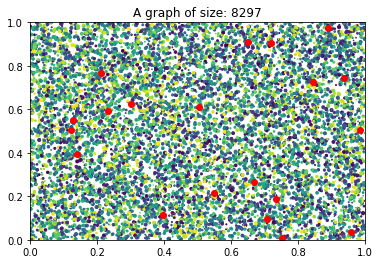

A seed set of size  20  found in  19.50986409187317  with a propogation value  114.88990534963239  using celf
[11, 766, 2688, 1549, 737, 2972, 1374, 2256, 784, 1972, 2145, 2565, 3352, 3459, 457, 6305, 2658, 1297, 1305, 5802]


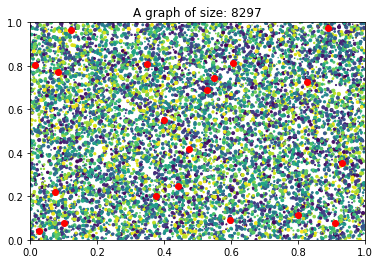

A seed set of size  20  found in  33.68468427658081  with a propogation value  129.60774506459845  using celf
[1549, 766, 2565, 11, 1151, 1166, 457, 2688, 2651, 1305, 789, 737, 2485, 3084, 2237, 722, 4045, 5524, 1378, 4335]


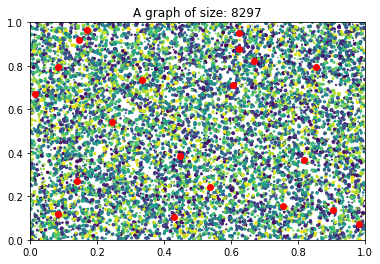

Common elements: {2688, 457, 766}


In [40]:
# TEST 2
%matplotlib inline
a = visualise(celf, wikivote, 20, 0.025, exponential, 5)
%matplotlib inline
b = visualise(celf, wikivote, 20, 0.025, exponential, 10)
%matplotlib inline
c = visualise(celf, wikivote, 20, 0.025, exponential, 15)

print("Common elements:", set(a) & set(b) & set(c))

In [24]:
def checkDegree(graph):
    """
    input: graph - a network
    output: degree of each node in the network from low to high
    """
    
    NId = snap.GetMxDegNId(graph)
    print("max degree node", NId)
    DegToCntV = snap.TIntPrV()
    snap.GetDegCnt(graph, DegToCntV)
    for item in DegToCntV:
        print("%d nodes with degree %d" % (item.GetVal2(), item.GetVal1()))

In [65]:
checkDegree(gen_ts_graph(8297, 11))

437700
Graph successfully generated! 

max degree node 1308
1 nodes with degree 73
1 nodes with degree 74
1 nodes with degree 75
5 nodes with degree 76
6 nodes with degree 77
6 nodes with degree 78
12 nodes with degree 79
10 nodes with degree 80
10 nodes with degree 81
11 nodes with degree 82
21 nodes with degree 83
32 nodes with degree 84
26 nodes with degree 85
43 nodes with degree 86
54 nodes with degree 87
46 nodes with degree 88
59 nodes with degree 89
95 nodes with degree 90
100 nodes with degree 91
104 nodes with degree 92
148 nodes with degree 93
151 nodes with degree 94
152 nodes with degree 95
183 nodes with degree 96
190 nodes with degree 97
219 nodes with degree 98
266 nodes with degree 99
229 nodes with degree 100
278 nodes with degree 101
284 nodes with degree 102
295 nodes with degree 103
307 nodes with degree 104
321 nodes with degree 105
321 nodes with degree 106
323 nodes with degree 107
333 nodes with degree 108
302 nodes with degree 109
309 nodes with degree 110
269

### Testing lt

In [25]:
def pvseedSetlt(method, graph, ff=exponential):
    """
    input: method - solving strategy, graph - network, p - activation probability, ff - freshness function
    output: propagation values of seed sets from 10 to 50 using linear threshold
    """
    mc = inputs()
    
    trials = []
    seedz = []
    i = 10
    
    while i <= 50:
        start = time.time()
        result = method(graph, i, int(mc))
        end = time.time()
        pVSim = lt(graph, result[0], int(mc), ff, 1)
        trials.append((str(i) + " seeds", str(round(end-start, 2)) + "s", str(round(pVSim, 2))  + " propagation value"))
        temp = "Seeds " + str(i) + ":" + str(result[0])
        seedz.append(textwrap.fill(temp, width=16, subsequent_indent=' ' * 3))
        i+=10
    
    for item in seedz:
        trials.append(item)
    
    return trials

#### Test 3

In [6]:
# TEST 3 - solving strategies on real world networks (estimate solve time 5 days)
for method in arraylt:
    resultslt = []

    print("Run " + str(method.__name__) + ", type yes or no")
    
    if not input() == "yes":
        continue
        
    for dataset in datasets:
        resultslt.append(pvseedSetlt(method, dataset) + [str(namestr(dataset, globals())[0])])
        print("Test finished for method : ", str(method.__name__), " on data set " ,str(namestr(dataset, globals())[0]))

    with open("Additional Tests/" + str(method.__name__) + " lt" +".txt", "w") as txt_file:
        for line2 in resultslt:
            for line in line2:
                txt_file.write(" ".join(str(line)) + "\n")

NameError: name 'arraylt' is not defined

In [26]:
def visualiselt(method, graph, seedSetSize, ff=exponential, mc=100):
    """
    input: method - solving strategy, graph - network, seedSetSize - size of seed set, ff - freshness function, mc - number of iterations  
    output: graph with seed set plotted
    """
    start = time.time()
    result = method(graph, seedSetSize, mc, ff)
    end = time.time()
    pVSim = lt(graph, result[0], mc, ff)

    print("A seed set of size ", seedSetSize, " found in ", end-start, " with a propagation value ", pVSim)
    print(result[0])
    
    # sketch the seed nodes
    graphSize = graph.GetNodes()
    
    # sketches the graph
    x, y, s, c = np.random.rand(4, graphSize)
    s *= 10
    figsrc, axsrc = plt.subplots()
    axsrc.set(xlim=(0, 1), ylim=(0, 1), autoscale_on=False, title='A graph of size: ' + str(graphSize-1000))
    axsrc.scatter(x, y, s, c)
    
    for node in result[0]:
        plt.plot(x[int(node)], y[int(node)], 'ro')
    
    plt.rcParams["figure.figsize"] = (200,100)
    plt.show()
    
    return result[0]

#### Test 4

A seed set of size  10  found in  5.670637130737305  with a propogation value  57.01301628212049
[4037, 402, 6774, 2470, 3976, 4261, 665, 15, 8293, 7301]


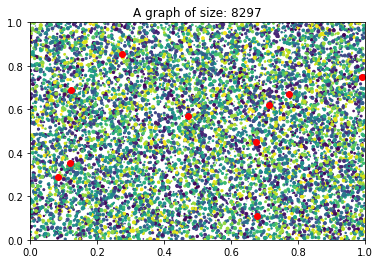

A seed set of size  10  found in  6.305724620819092  with a propogation value  54.500495230731
[4037, 4261, 825, 2237, 7131, 1186, 1705, 214, 3970, 2470]


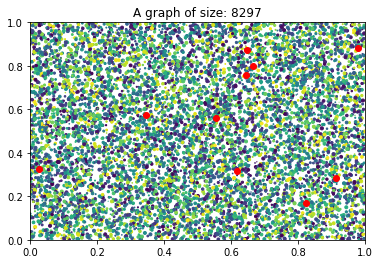

A seed set of size  10  found in  5.956794738769531  with a propogation value  58.947927326601
[4037, 6774, 4828, 2470, 1186, 4041, 2535, 95, 8293, 2285]


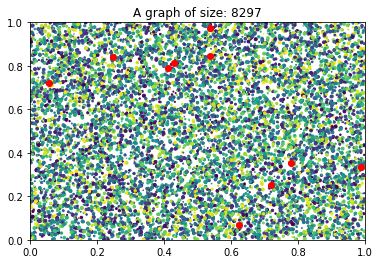

Common elements: {4037, 2470}


In [43]:
# TEST 4
%matplotlib inline
a = visualiselt(celflt, wikivote, 10, exponential, 5)
%matplotlib inline
b = visualiselt(celflt, wikivote, 10, exponential, 10)
%matplotlib inline
c = visualiselt(celflt, wikivote, 10, exponential, 15)

print("Common elements:", set(a) & set(b) & set(c))

## Test - feshness functions

In [31]:
localNetworks = [gen_ts_graph(5000, 10), gen_ts_graph(7000, 12), gen_ts_graph(10000, 13)]

Graph successfully generated! 

Graph successfully generated! 

Graph successfully generated! 



## PolynomialFreeDecay

#### Test 5

In [35]:
# TEST 5
for method in arrayic:
    resultslt = []
    
    print("Run " + str(method.__name__) + ", type yes or no")
    
    if not input() == "yes":
        continue
    
    for dataset in localNetworks:
        resultslt.append(pvseedSetic(method, dataset, 0.05, polynomialFreeDecay) + [str(namestr(dataset, globals())[0])])
        print("Test finished for method : ", str(method.__name__), " on data set " ,str(namestr(dataset, globals())[0]))

    with open("Additional Tests/" + str(method.__name__) + " polynomialfreedecayIC" +".txt", "w") as txt_file:
        for line2 in resultslt:
            for line in line2:
                txt_file.write(" ".join(str(line)) + "\n")

Run celf, type yes or no


 yes


Enter the number of simulations...


 10


Test finished for method :  celf  on data set  dataset
Enter the number of simulations...


 10


Test finished for method :  celf  on data set  dataset
Enter the number of simulations...


 10


Test finished for method :  celf  on data set  dataset
Run celfPlus, type yes or no


 no


Run degree, type yes or no


 no


Run tournamentSelection, type yes or no


 no


Run stochasticSampling, type yes or no


 no


#### Test 6

In [45]:
# TEST 6
for method in arraylt:
    resultslt = []
    
    print("Run " + str(method.__name__) + ", type yes or no")
    
    if not input() == "yes":
        continue
        
    for dataset in localNetworks:
        resultslt.append(pvseedSetlt(method, dataset, polynomialFreeDecay) + [str(namestr(dataset, globals())[0])])
        print("Test finished for method : ", str(method.__name__), " on data set " ,str(namestr(dataset, globals())[0]))

    with open("Additional Tests/" + str(method.__name__) + " polynomialfreedecayLT" +".txt", "w") as txt_file:
        for line2 in resultslt:
            for line in line2:
                txt_file.write(" ".join(str(line)) + "\n")

Test finished for method :  celflt  on data set  dataset
Test finished for method :  celflt  on data set  dataset
Test finished for method :  celflt  on data set  dataset
Test finished for method :  celfPluslt  on data set  dataset


KeyboardInterrupt: 

### Piecewiselinear

#### Test 7

In [125]:
# TEST 7
for method in arrayic:
    resultslt = []
    
    print("Run " + str(method.__name__) + ", type yes or no")
    
    if not input() == "yes":
        continue
    
    for dataset in localNetworks:
        resultslt.append(pvseedSetic(method, dataset, 0.05, piecewiselinear) + [str(namestr(dataset, globals())[0])])
        print("Test finished for method : ", str(method.__name__), " on data set " ,str(namestr(dataset, globals())[0]))

    with open("Additional Tests/" + str(method.__name__) + " piecewiseIC" +".txt", "w") as txt_file:
        for line2 in resultslt:
            for line in line2:
                txt_file.write(" ".join(str(line)) + "\n")

Test finished for method :  stochasticSampling  on data set  dataset
Test finished for method :  stochasticSampling  on data set  dataset
Test finished for method :  stochasticSampling  on data set  dataset


#### Test 8

In [122]:
# TEST 8
for method in arraylt:
    resultslt = []
    
    print("Run " + str(method.__name__) + ", type yes or no")
    
    if not input() == "yes":
        continue
        
    for dataset in localNetworks:
        resultslt.append(pvseedSetlt(method, dataset, piecewiselinear) + [str(namestr(dataset, globals())[0])])
        print("Test finished for method : ", str(method.__name__), " on data set " ,str(namestr(dataset, globals())[0]))

    with open("Additional Tests/" + str(method.__name__) + " piecewiseIC" +".txt", "w") as txt_file:
        for line2 in resultslt:
            for line in line2:
                txt_file.write(" ".join(str(line)) + "\n")

Test finished for method :  celflt  on data set  dataset
Test finished for method :  celflt  on data set  dataset
Test finished for method :  celflt  on data set  dataset
Test finished for method :  celfPluslt  on data set  dataset
Test finished for method :  celfPluslt  on data set  dataset
Test finished for method :  celfPluslt  on data set  dataset
Test finished for method :  degreelt  on data set  dataset
Test finished for method :  degreelt  on data set  dataset
Test finished for method :  degreelt  on data set  dataset
Test finished for method :  tournamentSelectionlt  on data set  dataset
Test finished for method :  tournamentSelectionlt  on data set  dataset
Test finished for method :  tournamentSelectionlt  on data set  dataset
Test finished for method :  stochasticSamplinglt  on data set  dataset
Test finished for method :  stochasticSamplinglt  on data set  dataset
Test finished for method :  stochasticSamplinglt  on data set  dataset


A seed set of size  20  found in  98.6335506439209  with a propagation value  78.93010629417554
[4037, 2237, 2470, 8293, 2328, 1186, 3334, 2565, 15, 6774, 55, 2285, 28, 214, 2643, 3459, 1285, 5321, 6780, 5484]


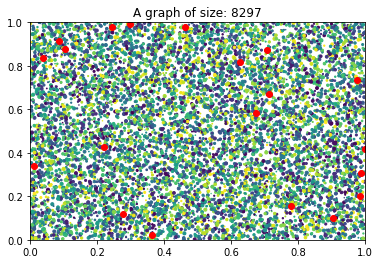

A seed set of size  20  found in  710.1232414245605  with a propagation value  86.15994965352566
[4037, 2237, 2470, 1186, 15, 2625, 28, 2285, 665, 5321, 4191, 7620, 8293, 214, 4261, 3459, 55, 3806, 2654, 6774]


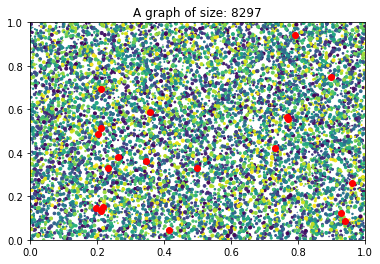

A seed set of size  20  found in  116.66595959663391  with a propagation value  89.99053100326095
[4037, 2237, 2470, 1186, 6774, 2237, 4261, 2285, 665, 8293, 4261, 2654, 15, 8178, 155, 4191, 7620, 2565, 214, 6634]


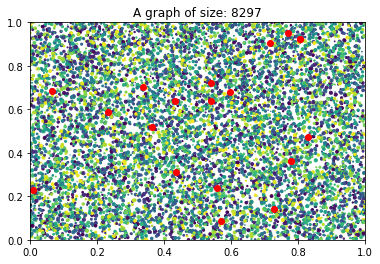

Common elements lt: {1186, 8293, 4037, 2470, 2285, 15, 214, 6774, 2237}
A seed set of size  20  found in  43.5822491645813  with a propagation value  93.79482170893321  using celf
[1549, 1166, 2972, 2565, 2658, 3724, 2145, 2485, 2576, 2256, 7791, 7101, 4191, 3258, 2871, 766, 311, 813, 3537, 15]


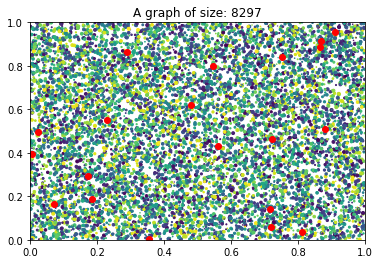

A seed set of size  20  found in  203.51670479774475  with a propagation value  104.46003538007567  using tournamentSelection
[1166, 5022, 11, 4967, 766, 5860, 1374, 2535, 1352, 5802, 4037, 2667, 3394, 3352, 2565, 1159, 988, 5012, 4099, 311]


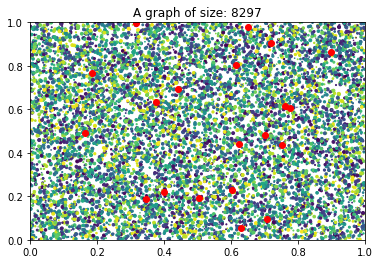

A seed set of size  20  found in  43.19875121116638  with a propagation value  94.7614677804681  using stochasticSampling
[2565, 5524, 1374, 457, 2871, 3352, 1374, 2815, 766, 789, 3459, 7510, 3796, 4929, 2815, 3191, 2542, 2688, 2398, 2658]


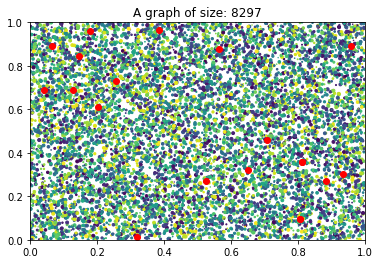

Common elements ic: {2565, 766}


In [30]:
# Presentation code -ommitted-

# linear threshold
%matplotlib inline
a = visualiselt(celflt, wikivote, 20, exponential, 5)
%matplotlib inline
b = visualiselt(tournamentSelectionlt, wikivote, 20, exponential, 5)
%matplotlib inline
c = visualiselt(stochasticSamplinglt, wikivote, 20, exponential, 5)

print("Common elements lt:", set(a) & set(b) & set(c))

# independent cascade
%matplotlib inline
a = visualise(celf, wikivote, 20, 0.025, exponential, 5)
%matplotlib inline
b = visualise(tournamentSelection, wikivote, 20, 0.025, exponential, 5)
%matplotlib inline
c = visualise(stochasticSampling, wikivote, 20, 0.025, exponential, 5)

print("Common elements ic:", set(a) & set(b) & set(c))